In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 进度条工具

import torch
import torch.nn as nn
import torch.nn.functional as F
# transforms提供了数据处理工具
import torchvision.transforms as transforms 
# 由于数据集较大，我们通过工具在线下载数据集
from torchvision.datasets import CIFAR10 
from torch.utils.data import DataLoader

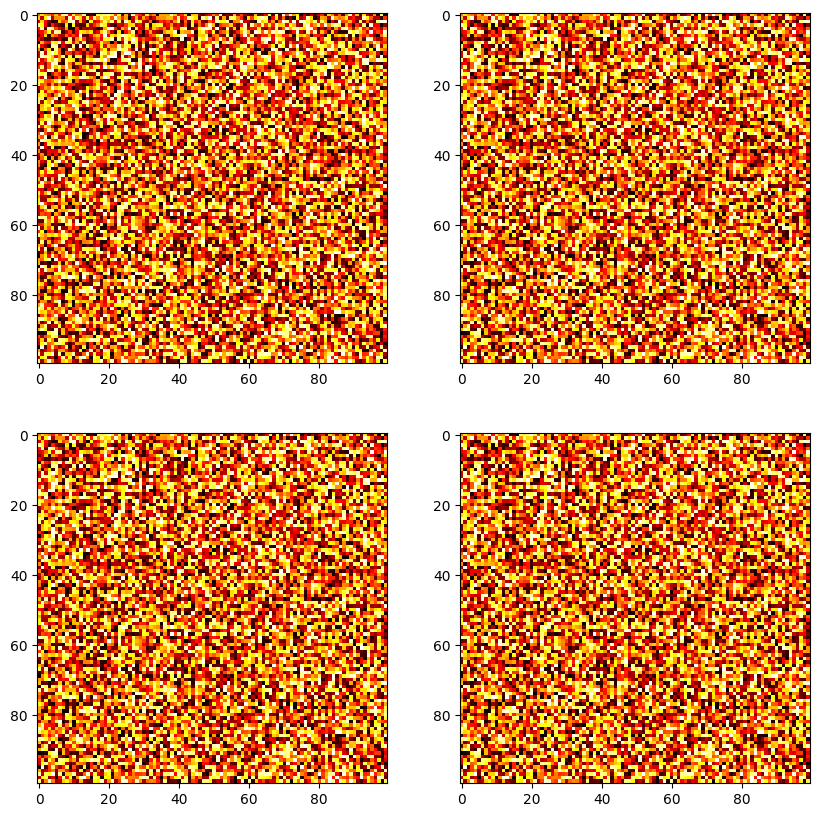

In [50]:
data=np.random.rand(100,100)
fig,axes=plt.subplots(2,2,figsize=(10,10))
for i in range(2):
    for j in range(2):
        axes[i][j].imshow(data,cmap='hot')

训练集大小： 50000
测试集大小： 10000


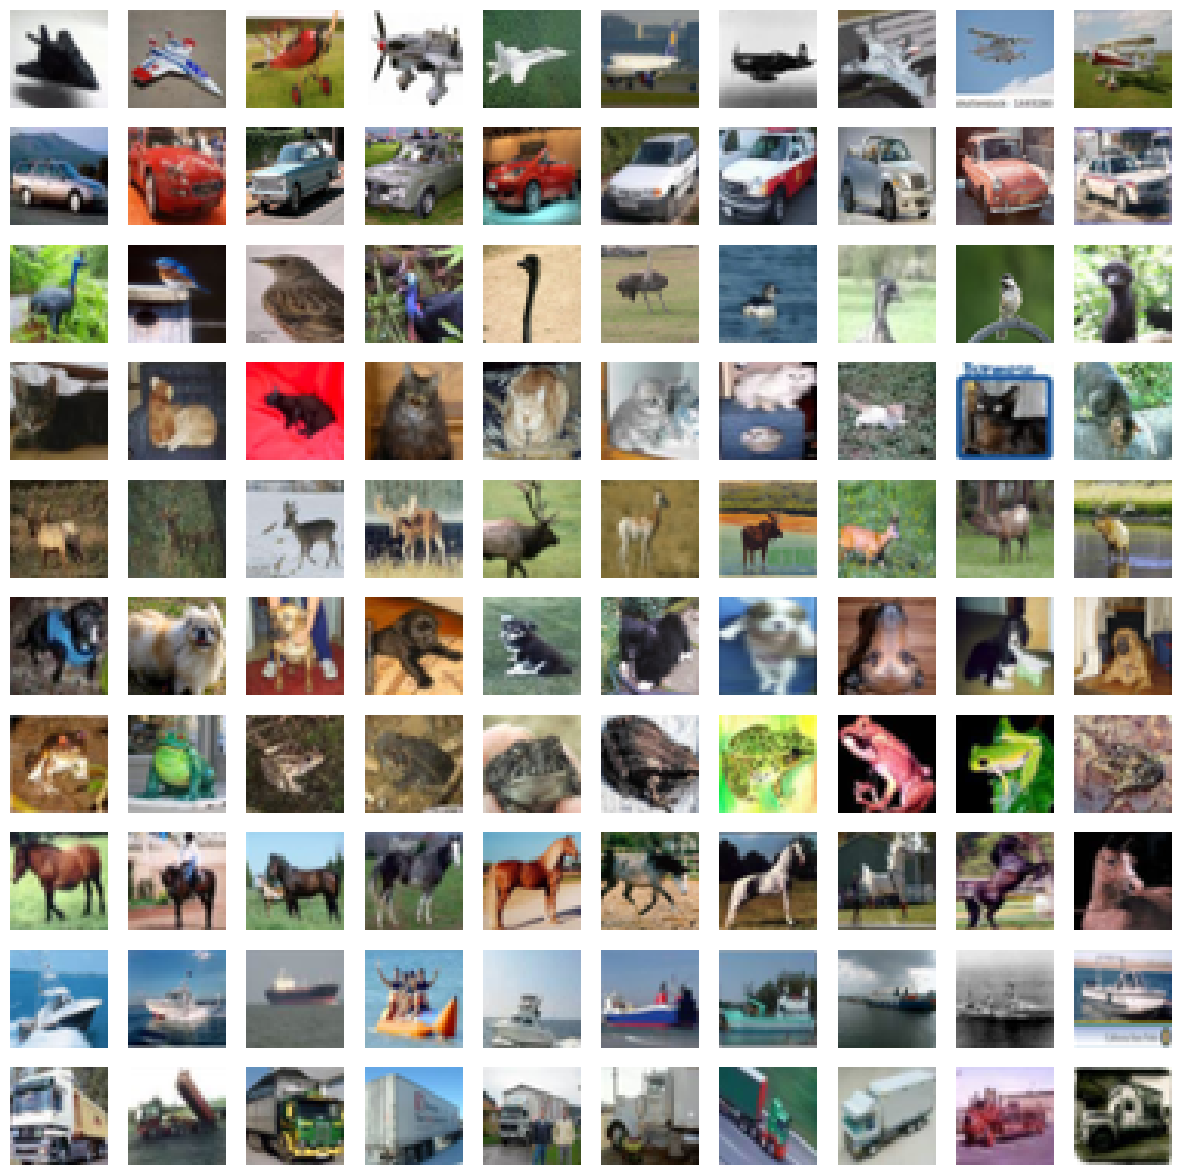

In [51]:
# 下载训练集和测试集
data_path = './cifar10'
trainset = CIFAR10(root=data_path, train=True, 
    download=True, transform=transforms.ToTensor())
testset = CIFAR10(root=data_path, train=False, 
    download=True, transform=transforms.ToTensor())
print('训练集大小：', len(trainset))
print('测试集大小：', len(testset))

num_classes=10
fig,axes=plt.subplots(num_classes,10,figsize=(15,15))
labels=np.array([t[1] for t in trainset])

for i in range(num_classes):
    indices=np.where(labels==i)[0]#取出类别为i的图像的下标（默认返回元组，需要获取第一个元组）
    for j in range(10):
        axes[i][j].imshow(trainset[indices[j]][0].permute(1,2,0).numpy())
        axes[i][j].axis('off')
plt.show()

In [52]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.num_classes=num_classes
        # 输入通道、输出通道、卷积核大小、填充
        self.conv1=nn.Conv2d(3,32,3,padding=1)
        self.conv2=nn.Conv2d(32,32,3,padding=1)
        self.pooling1=nn.MaxPool2d(2,2)
        self.dropout1=nn.Dropout(0.25)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        self.conv4=nn.Conv2d(64,64,3,padding=1)
        self.pooling2=nn.MaxPool2d(2,2)
        self.dropout2=nn.Dropout(0.25)

        self.fc1=nn.Linear(64*8*8,512)
        self.dropout3=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,num_classes)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=self.pooling1(x)
        x=self.dropout1(x)

        x=F.relu(self.conv3(x))
        x=F.relu(self.conv4(x))
        x=self.pooling2(x)
        x=self.dropout2(x)

        x=x.view(len(x),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout3(x)
        x=self.fc2(x)
        return x



In [53]:
device=torch.device("mps")
batch_size = 64 # 批量大小
learning_rate = 1e-3 # 学习率
epochs = 1 # 训练轮数
np.random.seed(0)
torch.manual_seed(0)

trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size=batch_size,shuffle=False)

model=CNN().to(device)

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=F.cross_entropy

for epoch in range(epochs):
    losses=0
    accs=0
    num=0
    model.train()
    with tqdm(trainloader) as pbar:
        for data in pbar:
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num+=len(labels)
            losses += loss.detach().cpu().numpy() * len(labels)   
            accs += (torch.argmax(outputs, dim=-1) == labels).sum().detach().cpu().numpy()
            pbar.set_postfix({
                'Epoch': epoch, 
                'Train loss': f'{losses / num:.3f}', 
                'Train acc': f'{accs / num:.3f}'
            })
    
    # 计算模型在测试集上的表现
    losses = 0
    accs = 0
    num = 0
    model.eval() # 将模型设置为评估模式，关闭dropout
    with tqdm(testloader) as pbar:
        for data in pbar:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            num += len(labels)
            # losses += loss.detach().numpy() * len(labels)
            # accs += (torch.argmax(outputs, dim=-1) \
            #     == labels).sum().detach().numpy()
            losses += loss.detach().cpu().numpy() * len(labels)   
            accs += (torch.argmax(outputs, dim=-1) == labels).sum().detach().cpu().numpy()
            pbar.set_postfix({
                'Epoch': epoch, 
                'Test loss': f'{losses / num:.3f}', 
                'Test acc': f'{accs / num:.3f}'
            })



 13%|█▎        | 104/782 [00:08<00:52, 12.99it/s, Epoch=0, Train loss=2.065, Train acc=0.223]


KeyboardInterrupt: 

(1797, 64)


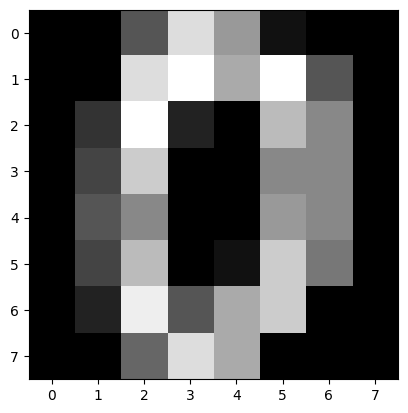

In [54]:
# 手写数字识别
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits=load_digits()
x,y=digits.data,digits.target
print(x.shape)
# plt.imshow(digits.images[0],cmap='gray')
plt.imshow(x[0].reshape(8,8),cmap='gray')
plt.show()

In [55]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # self.conv1 = nn.Conv2d(1, 16, 3, padding=1)     # 输入通道 1，输出通道减少
        # self.pool1 = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout=nn.Dropout(0.3)
        # self.fc1 = nn.Linear(32 * 2 * 2, 64)            # 更小的全连接层
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.gap(x)
        x = x.view(len(x), -1)
        # x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [56]:
ratio=0.8
num_train=int(len(x)*ratio)
x_train,y_train=x[:num_train],y[:num_train]
x_test,y_test=x[num_train:],y[num_train:]
print(x_train.shape,y_train.shape)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


(1437, 64) (1437,)


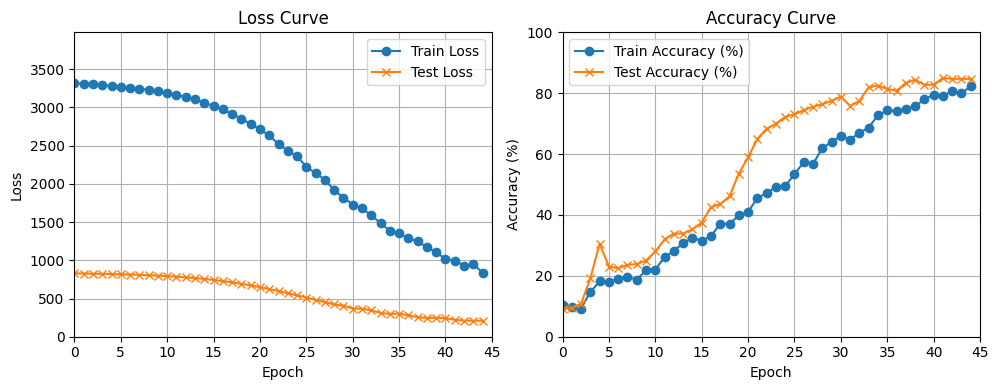

最终训练集准确率：82.32%
最终测试集准确率：84.72%


In [57]:
from IPython.display import clear_output
device = torch.device("mps")
batch_size = 64
learning_rate = 1e-3
epochs = 45
np.random.seed(0)
torch.manual_seed(0)

model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = F.cross_entropy

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    model.train()
    x_train, y_train = x_train.to(device), y_train.to(device)
    outputs = model(x_train.reshape(-1, 1, 8, 8))
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item() * len(y_train))
    train_acc.append((torch.argmax(outputs, dim=-1) == y_train).float().mean().item()*100)

    model.eval()
    with torch.no_grad():
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test.reshape(-1, 1, 8, 8))
        loss = criterion(outputs, y_test)
        test_loss.append(loss.item() * len(y_test))
        test_acc.append((torch.argmax(outputs, dim=-1) == y_test).float().mean().item() * 100)
    # 固定坐标轴绘图
    if epoch % 2 == 0 or epoch == epochs - 1:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))

        # Loss 图
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Train Loss', marker='o')
        plt.plot(test_loss, label='Test Loss', marker='x')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.grid(True)
        plt.xlim(0, epochs)
        max_loss = max(train_loss + test_loss)
        plt.ylim(0, max(0.5, max_loss * 1.2))  # 自动扩展但不跳动

        # Accuracy 图（百分比）
        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label='Train Accuracy (%)', marker='o')
        plt.plot(test_acc, label='Test Accuracy (%)', marker='x')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy Curve')
        plt.legend()
        plt.grid(True)
        plt.xlim(0, epochs)
        plt.ylim(0, 100)

        plt.tight_layout()
        plt.show()
final_train_acc = train_acc[-1]
final_test_acc = test_acc[-1]
print(f"最终训练集准确率：{final_train_acc:.2f}%")
print(f"最终测试集准确率：{final_test_acc:.2f}%")

最终训练集准确率：95.34%
最终测试集准确率：85.56%
在全连接第一层添加dropout之后，
最终训练集准确率：89.63%
最终测试集准确率：85.56%



使用设备：mps
内容图像


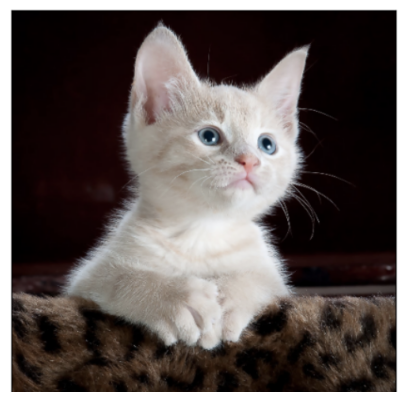

风格图像


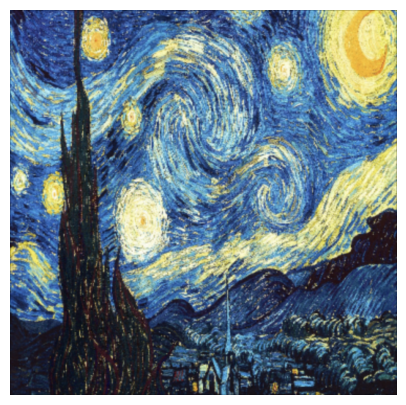

In [58]:
# 风格迁移
# 该工具包中有AlexNet、VGG等多种训练好的CNN网络
# 风格迁移
from torchvision import models, transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

import copy

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备：{device}")

# VGG 预处理的均值/方差
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# 反归一化用于可视化（把张量还原到[0,1]）
def deprocess(t):
    mean = torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1).to(t.device)
    std  = torch.tensor(IMAGENET_STD).view(1, 3, 1, 1).to(t.device)
    x = t.detach() * std + mean
    x = x.clamp(0, 1)
    return x

# 加载图像，统一转成RGB、缩放到size、ToTensor并做VGG归一化
def loadimg(path, size=512, show=True):
    # 1) 统一成RGB三通道，消除alpha/灰度等差异
    pil = Image.open(path).convert('RGB')

    # 2) 可视化原图（未归一化）
    if show:
        plt.figure(figsize=(5, 5))
        plt.imshow(pil)
        plt.axis('off')
        plt.show()

    # 3) 预处理：Resize -> ToTensor(变为CHW且归一化到[0,1]) -> Normalize(符合VGG)
    tfm = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    img = tfm(pil).unsqueeze(0).to(device, dtype=torch.float32)  # [1,3,H,W]
    return img

content_image_path = 'content.jpg'
style_image_path = 'style.jpg'



print('内容图像')
content_img = loadimg(content_image_path, size=512, show=True)

print('风格图像')
style_img = loadimg(style_image_path, size=512, show=True)

# 如果你后面直接imshow训练中的张量（已做Normalize），请先反归一化：
# plt.imshow(deprocess(input_img)[0].cpu().permute(1,2,0).numpy()); plt.axis('off'); plt.show()

In [59]:
# 内容损失
class ContentLoss(nn.Module):

    def __init__(self, target):
        # target为从目标图像中提取的内容特征
        super().__init__()
        # 我们不对target求梯度，因此将target从梯度的计算图中分离出来
        self.target = target.detach() 
        self.criterion = nn.MSELoss()

    def forward(self, x):
         # 利用MSE计算输入图像与目标内容图像之间的损失
        self.loss = self.criterion(x, self.target) 
        return x # 只计算损失，不改变输入




def gram(x):
    # 计算G矩阵
    batch_size, n, w, h = x.shape # n为卷积核数目，w和h为输出的宽和高
    f = x.view(batch_size * n, w * h) # 变换为二维
    g = f @ f.T / (batch_size * n * w * h) # 除以参数数目，进行归一化
    return g


# 风格损失
class StyleLoss(nn.Module):

    def __init__(self, target):
        # target为从目标图像中提取的风格特征
        # weight为设置的强度系数lambda
        super().__init__()
        
        self.target = target.detach().to(device)
        self.target_gram = gram(target.detach().to(device))
        self.criterion = nn.MSELoss()

    def forward(self, x):
        input_gram = gram(x.clone()) # 输入的Gram矩阵
        self.loss = self.criterion(input_gram, self.target_gram)
        return x



In [62]:
# 导入并冻结VGG16，然后移动到 MPS 设备
vgg16 = models.vgg16(weights='IMAGENET1K_V1').features.to(device).eval()
for param in vgg16.parameters():
    param.requires_grad = False

# 选定用于提取特征的卷积层，Conv_13对应着第5块的第3卷积层
content_layer = ['Conv_13']
# 下面这些层分别对应第1至5块的第1卷积层
style_layer = ['Conv_1', 'Conv_3', 'Conv_5', 'Conv_8', 'Conv_11']

content_losses = [] # 内容损失
style_losses = [] # 风格损失

model = nn.Sequential().to(device) # 储存新模型的层
vgg16 = copy.deepcopy(vgg16)
index = 1  # 计数卷积层

# 遍历 VGG16 的网络结构，选取需要的层
for layer in list(vgg16):
    if isinstance(layer, nn.Conv2d): # 如果是卷积层
        name = "Conv_" + str(index)
        model.append(layer)
        if name in content_layer:  
            # 如果当前层用于抽取内容特征，则添加内容损失
            target = model(content_img).detach() # 计算内容图像的特征
            content_loss = ContentLoss(target) # 内容损失模块
            model.append(content_loss)
            content_losses.append(content_loss)

        if name in style_layer:  
            # 如果当前层用于抽取风格特征，则添加风格损失
            target = model(style_img).detach()
            style_loss = StyleLoss(target) # 风格损失模块
            model.append(style_loss)  
            style_losses.append(style_loss) 

    if isinstance(layer, nn.ReLU): # 如果激活函数层
        model.append(nn.ReLU(inplace=False))
        index += 1 #在 VGG 中，每个卷积层几乎都紧跟一个 ReLU

    if isinstance(layer, nn.MaxPool2d): # 如果是池化层
        model.append(layer)

# 输出模型结构
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): StyleLoss(
    (criterion): MSELoss()
  )
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): StyleLoss(
    (criterion): MSELoss()
  )
  (8): ReLU()
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): StyleLoss(
    (criterion): MSELoss()
  )
  (14): ReLU()
  (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): MaxPool2d(kernel_size=2, stride=2, padding=

训练轮数：19, 风格损失：0.0045, 内容损失：10.9940


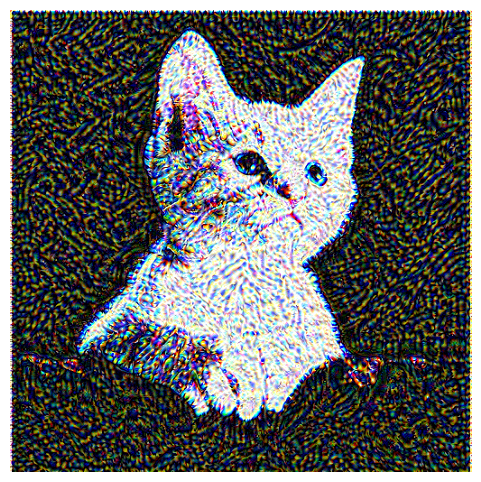

In [63]:
from IPython.display import clear_output
epochs = 20
learning_rate = 0.05
lbd = 1e6 # 强度系数

param = content_img.clone().detach().to(device).requires_grad_(True)
optimizer = torch.optim.Adam([param], lr=learning_rate) # 使用Adam优化器

for i in range(epochs):
    style_score = 0  # 本轮的风格损失
    content_score = 0  # 本轮的内容损失
    model(param) # 将输入通过模型，得到损失
    content_score = sum(cl.loss for cl in content_losses)
    style_score   = sum(sl.loss for sl in style_losses)
    loss = content_score + lbd * style_score
    # 更新输入图像
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 每次对输入图像进行更新后
    # 图像中部分像素点会超出0-1的范围
    # 因此要对其进行剪切
    param.data.clamp_(0, 1) 

    clear_output(wait=True)
    print(f'训练轮数：{i}, 风格损失：{style_score.item():.4f}, 内容损失：{content_score.item():.4f}')
    plt.figure(figsize=(6, 6))
    img = input_img[0].detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()